Plotting isentropic maps from the GFS analysis 
========================================

Following MetPy example: https://unidata.github.io/MetPy/latest/examples/isentropic_example.html

Imports

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
import scipy.ndimage as ndimage
import xarray as xr
import pandas as pd

import metpy.calc as mpcalc
from metpy.units import units

from palettable.colorbrewer.diverging import BrBG_11

enDash = u'\u2013'

Accessing data using Xarray
---------------------------

In [2]:
# Specify our date/time of product desired
dt = datetime(2025, 1, 29, 12)  ## year, month, day, hour, minute, second

archived = False ### is this an old time (more than ~1 month ago), where we need to get from NOMADS?
archived_old = False  ### or is it a *really* old time (more than ~1 year ago), to get from a different spot

if archived==True:
    #########for archived data, use NCEI below:
    base_url = "https://www.ncei.noaa.gov/thredds/dodsC/model-gfs-g4-anl-files/"
    data = xr.open_dataset(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/'
                           f'gfs_4_{dt:%Y%m%d}_{dt:%H}00_000.grb2',
                           decode_times=True)

if archived_old==True:
    #########for archived data, use NCEI below:
    base_url = "https://www.ncei.noaa.gov/thredds/dodsC/model-gfs-g4-anl-files-old/"
    data = xr.open_dataset(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/'
                           f'gfsanl_4_{dt:%Y%m%d}_{dt:%H}00_000.grb2',
                           decode_times=True)
    
else:
    ########### for near-real-time data, use unidata thredds
    base_url = "https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg_ana/"
    data = xr.open_dataset(f'{base_url}GFS_Global_0p5deg_ana_{dt:%Y%m%d}_{dt:%H}00.grib2',
                           decode_times=True)

    
    

In [3]:
data

<xarray.Dataset> Size: 634MB
Dimensions:                                                          (lat: 361,
                                                                      lon: 720,
                                                                      time: 1,
                                                                      altitude_above_msl: 3,
                                                                      sigma_layer: 4,
                                                                      pressure_difference_layer: 1,
                                                                      ...
                                                                      sigma: 1,
                                                                      pressure_difference_layer1: 1,
                                                                      hybrid: 1,
                                                                      sigma_layer_bounds_1: 2,
                                                                      pressure_difference_layer_bounds_1: 2,
                                                                      pressure_difference_layer1_bounds_1: 2)
Coordinates: (12/15)
  * lat                                                              (lat) float32 1kB ...
  * lon                                                              (lon) float32 3kB ...
    reftime                                                          datetime64[ns] 8B ...
  * time                                                             (time) datetime64[ns] 8B ...
  * altitude_above_msl                                               (altitude_above_msl) float32 12B ...
  * sigma_layer                                                      (sigma_layer) float32 16B ...
    ...                                                               ...
  * height_above_ground                                              (height_above_ground) float32 8B ...
  * potential_vorticity_surface                                      (potential_vorticity_surface) float32 8B ...
  * height_above_ground1                                             (height_above_ground1) float32 24B ...
  * sigma                                                            (sigma) float32 4B ...
  * pressure_difference_layer1                                       (pressure_difference_layer1) float32 4B ...
  * hybrid                                                           (hybrid) float32 4B ...
Dimensions without coordinates: sigma_layer_bounds_1,
                                pressure_difference_layer_bounds_1,
                                pressure_difference_layer1_bounds_1
Data variables: (12/83)
    LatLon_Projection                                                int32 4B ...
    sigma_layer_bounds                                               (sigma_layer, sigma_layer_bounds_1) float32 32B ...
    pressure_difference_layer_bounds                                 (pressure_difference_layer, pressure_difference_layer_bounds_1) float32 8B ...
    pressure_difference_layer1_bounds                                (pressure_difference_layer1, pressure_difference_layer1_bounds_1) float32 8B ...
    Absolute_vorticity_isobaric                                      (time, isobaric, lat, lon) float32 43MB ...
    Cloud_mixing_ratio_hybrid                                        (time, hybrid, lat, lon) float32 1MB ...
    ...                                                               ...
    v-component_of_wind_potential_vorticity_surface                  (time, potential_vorticity_surface, lat, lon) float32 2MB ...
    v-component_of_wind_maximum_wind                                 (time, lat, lon) float32 1MB ...
    v-component_of_wind_altitude_above_msl                           (time, altitude_above_msl, lat, lon) float32 3MB ...
    v-component_of_wind_height_above_ground                          (time, height_above_ground1, lat, lon) float32 6MB ...
    v-component

Convert time in file to pandas datetime

In [4]:
#vtime = pd.to_datetime(data.time)[0]
vtime = pd.to_datetime(dt)
vtime


Timestamp('2025-01-29 12:00:00')

Get relevant variables

In [5]:
data_subset = data.metpy.parse_cf([
    'u-component_of_wind_isobaric',
    'v-component_of_wind_isobaric',
    'Temperature_isobaric',
    'Geopotential_height_isobaric',
    'Relative_humidity_isobaric',
    'Geopotential_height_surface',
   # 'Relative_humidity_height_above_ground',
    'Pressure_reduced_to_MSL_msl',
    'u-component_of_wind_height_above_ground',
    'v-component_of_wind_height_above_ground' 
]).sel(time=vtime).squeeze()

## subset to North America ; need to load data in to do the interpolation
data_subset = data_subset.sel(lon=slice(205,310.), lat=slice(68.,18.))

Inspect data:

In [6]:
data_subset

<xarray.Dataset> Size: 19MB
Dimensions:                                  (lat: 101, lon: 211, isobaric: 41,
                                              height_above_ground1: 6)
Coordinates:
  * lat                                      (lat) float32 404B 68.0 ... 18.0
  * lon                                      (lon) float32 844B 205.0 ... 310.0
    reftime                                  datetime64[ns] 8B 2025-01-29T12:...
    time                                     datetime64[ns] 8B 2025-01-29T12:...
  * isobaric                                 (isobaric) float32 164B 1.0 ... ...
    metpy_crs                                object 8B Projection: latitude_l...
  * height_above_ground1                     (height_above_ground1) float32 24B ...
Data variables:
    u-component_of_wind_isobaric             (isobaric, lat, lon) float32 3MB ...
    v-component_of_wind_isobaric             (isobaric, lat, lon) float32 3MB ...
    Temperature_isobaric                     (isobaric, lat, lon) float32 3MB ...
    Geopotential_height_isobaric             (isobaric, lat, lon) float32 3MB ...
    Relative_humidity_isobaric               (isobaric, lat, lon) float32 3MB ...
    Geopotential_height_surface              (lat, lon) float32 85kB ...
    Pressure_reduced_to_MSL_msl              (lat, lon) float32 85kB ...
    u-component_of_wind_height_above_ground  (height_above_ground1, lat, lon) float32 511kB ...
    v-component_of_wind_height_above_ground  (height_above_ground1, lat, lon) float32 511kB ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

Set up and run interpolation to isentropic surfaces
----------------------

In [11]:
isentlevs = [306.] * units.kelvin

isent_data = mpcalc.isentropic_interpolation_as_dataset(
    isentlevs,
    data_subset['Temperature_isobaric'],
    data_subset['u-component_of_wind_isobaric'],
    data_subset['v-component_of_wind_isobaric'],
    data_subset['Relative_humidity_isobaric'],
    data_subset['Geopotential_height_isobaric']
).squeeze()

### calculate mixing ratio from RH

In [12]:
isent_data['mixing_ratio'] = mpcalc.mixing_ratio_from_relative_humidity(isent_data['pressure'],
                                                                         isent_data['temperature'],
                                                                         isent_data['Relative_humidity_isobaric']).metpy.convert_units('g/kg')


In [13]:
isent_data

Magnitude,[[302.8243713378906 304.41314697265625 305.88323974609375 ... 247.4717254638672 247.50039672851562 247.24559020996094] [309.2068786621094 310.3244323730469 310.7838134765625 ... 246.5060577392578 246.9391326904297 247.2839813232422] [312.64434814453125 313.43487548828125 314.3069152832031 ... 244.63389587402344 244.56988525390625 244.1154327392578] ... [734.953857421875 740.0179443359375 752.8133544921875 ... 801.7342529296875 802.368896484375 800.1991577148438] [736.3568725585938 755.802734375 756.0537719726562 ... 804.7068481445312 802.4454956054688 802.1510009765625] [761.6317138671875 767.6822509765625 770.1475830078125 ... 802.701904296875 800.8468017578125 802.9203491210938]]
Units,hectopascal
Magnitude,[[217.51551241744176 217.84095227943777 218.14102171769838 ... 205.32556093669984 205.33236063169292 205.27193468439364] [218.81562380524332 219.04129471990404 219.1338747068869 ... 205.09632683110132 205.19920801804983 205.28104555928323] [219.50790682496623 219.66633628610603 219.8407713714738 ... 204.65006083500498 204.6347576160839 204.52605320500746] ... [280.2270283925227 280.7773568832517 282.15595117824114 ... 287.277462804045 287.34242210571176 287.120202921476] [280.37976597390775 282.47563997950965 282.5024377794235 ... 287.5813839995429 287.3502384963702 287.3201010926029] [283.096369363249 283.7371129074975 283.99716413749155 ... 287.3764892411014 287.1865691087218 287.39881901665336]]
Units,kelvin
Magnitude,[[-3.5736763157237315 -4.074844689619416 -4.654781722378328 ... 7.300531226537614 7.624587653513254 8.122597624063973] [-2.4566759295573464 -2.7152141727896213 -3.069563102993169 ... 7.658329361142832 8.01734542623425 8.45387830964513] [-0.6545107692723966 -0.6606646483941301 -0.6303474118361101 ... 7.531775337994457 8.250373344642902 9.447318624534569] ... [4.842962961503019 3.921663258199696 4.682174314102335 ... -8.592150750592207 -8.785488653451418 -8.970870318575464] [4.187113916807144 4.301587785595901 4.634952949632712 ... -8.67127665820389 -8.9351067285435 -9.07135631023064] [3.973914082620189 4.025923519993497 4.434518652222301 ... -8.655311663359157 -8.526252562102753 -9.533085992136824]]
Units,meter/second
Magnitude,[[-5.813979509552281 -5.368801998216223 -5.155534667058642 ... 21.36605180595503 21.47640496609092 21.48250578186019] [-7.555670064758469 -6.769961808461676 -6.167944731740194 ... 22.798185954290716 22.549371060709586 22.37977538557603] [-8.042617382512848 -7.326037898172904 -6.399588715895246 ... 24.663676255103255 25.359429441057443 26.19590895017906] ... [5.159445419956463 5.114565621929242 7.092456083951586 ... 0.034567823533111275 -0.20723318321376727 -0.27099043180232574] [5.2958603789598415 5.966922317708221 6.396436957229558 ... -1.6139155508310643 -1.0629675963944685 -0.9242702949511674] [5.4664642172623665 5.9268259802469325 6.263943481566693 ... -1.0164332924256474 -0.693269631331658 -0.1072220234083896]]
Units,meter/second
Magnitude,[[17.071161983985185 15.485408193177507 15.036357798618212 ... 79.99171909750365 82.28100596599474 88.40378715984961] [14.852465136079692 13.968582673278753 13.152883431475232 ... 76.62586306535253 73.44839384022164 74.93366524689073] [12.60354695466452 12.008182813355226 11.226937044538458 ... 78.47055222164207 77.6451382610661 80.8470651792436] ... [52.322359471985614 56.66019680811754 32.61175550601864 ... 13.852160037928037 15.744133300803313 17.462718677425983] [49.35631261579488 27.826588952142377 27.61135161140288 ... 16.87111725337791 20.31992702237787 15.923994797407175] [26.69100593415108 28.334365920355495 29.71253079939351 ... 18.83704128912032 17.761328662000295 18.28963464206221]]
Units,percent
Magnitude,[[8331.342514535165 8294.701360395446 8260.976800653285 ... 9552.346448109296 9557.375415494578 9569.004007549236] [8190.271812666557 8164.091062475629 8151.508962683318 ... 9580.596385411 9577.707872179102 9577.463992253168] [8115.473878702098 8095.865703264738 8074.4786502525 ... 9631.768938703382 9640.261690720816 9

And make the map
---------------

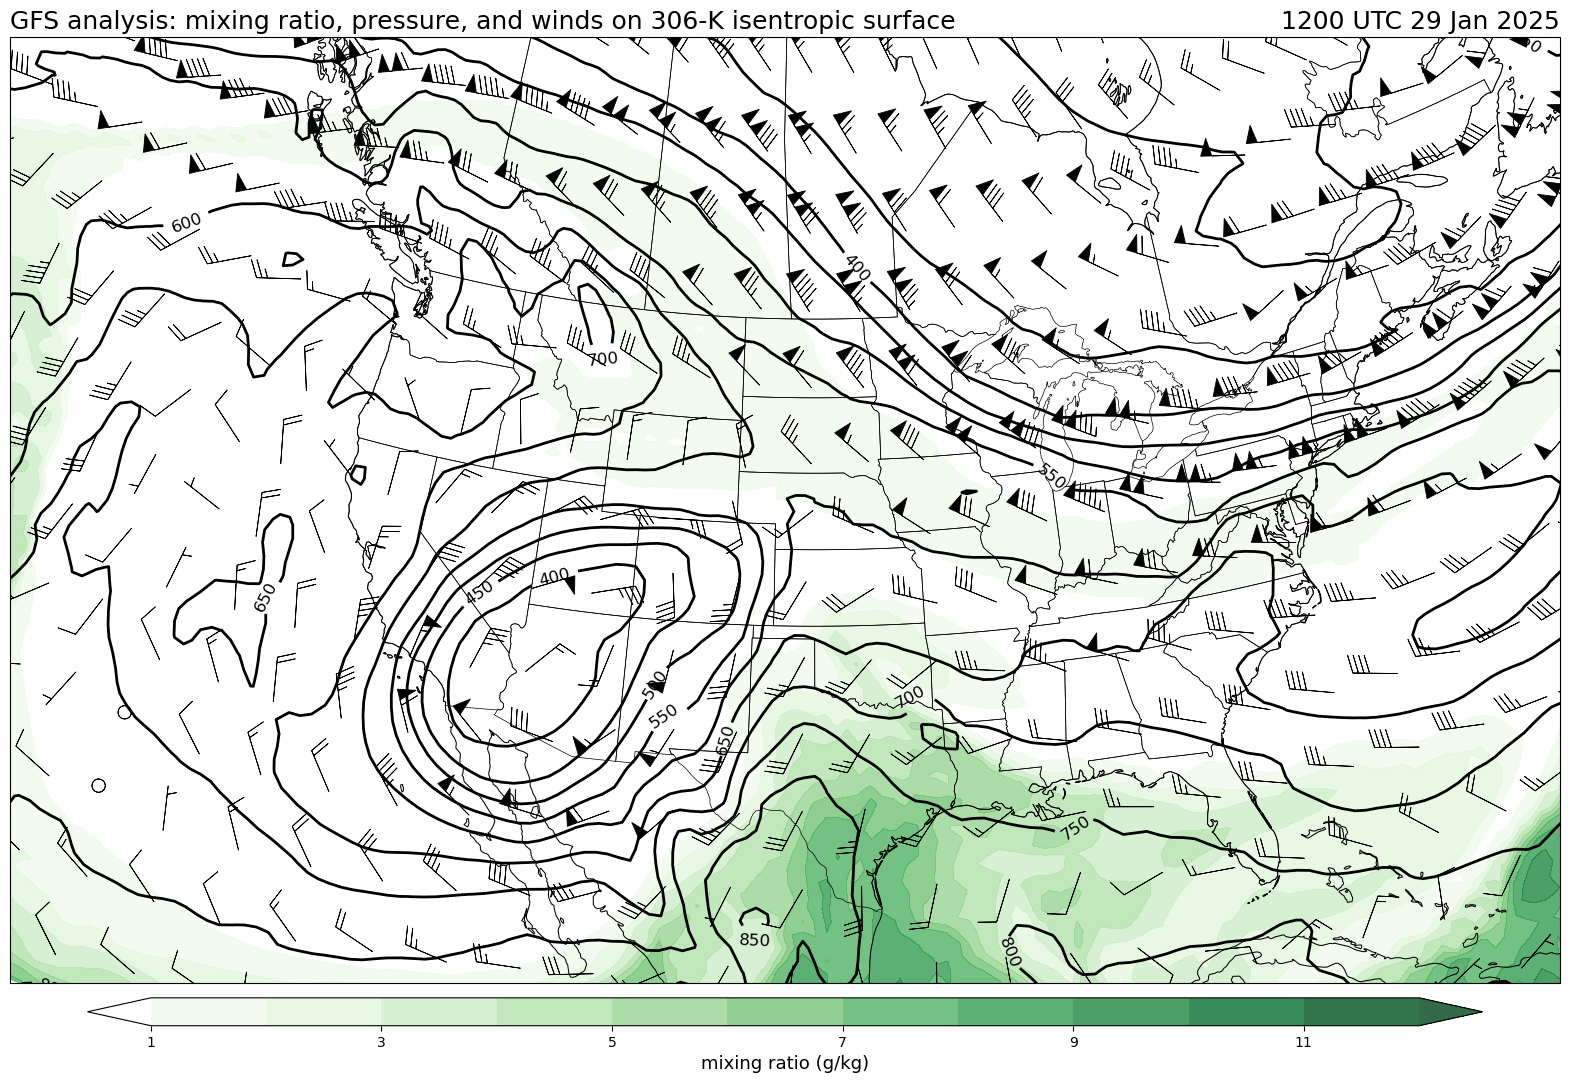

In [14]:
### smooth the pressure 
isent_prs = mpcalc.smooth_n_point(isent_data['pressure'], 9)

# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=45, central_longitude=-100)

fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=plotcrs)

# Plot Titles
plt.title("GFS analysis: mixing ratio, pressure, and winds on "+str(int(isentlevs.m[0]))+"-K isentropic surface",
          loc='left', fontsize=18)
plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=18)

# Plot Background
#ax.set_extent([217.5, 290., 18., 66.])
ax.set_extent([227.5, 290., 20., 56.])
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=.5)

# Plot pressure contours
clev_press = np.arange(0,1025,50)
cs = ax.contour(data_subset.lon, data_subset.lat, isent_prs, clev_press, 
                colors='black', linewidths=2,
                linestyles='solid', transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

### color contour RH
#clevs_rh = np.arange(60, 105, 5)
#cf = ax.contourf(data_subset.lon, data_subset.lat, isent_data['Relative_humidity_isobaric'], clevs_rh, alpha=0.8,
#                 cmap='Greens', extend='both', transform=datacrs)
#cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50, shrink=0.9)
#cb.set_label('relative humidity (%)', fontsize=13)

### make colormap with white appended to the beginning of "Greens"
cmap0 = LinearSegmentedColormap.from_list('', ['white', *plt.cm.Greens(np.arange(255))])

### color contour mixing ratio
clevs_q = np.arange(1, 13, 1)
cf = ax.contourf(data_subset.lon, data_subset.lat, isent_data['mixing_ratio'], clevs_q, alpha=0.8,
                 cmap=cmap0, extend='both', transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50, shrink=0.9)
cb.set_label('mixing ratio (g/kg)', fontsize=13)


# Plot Wind Barbs
# Transform Vectors and plot wind barbs.
wind_slice = slice(None, None, 6)
ax.barbs(data_subset.lon[wind_slice], data_subset.lat[wind_slice], 
         isent_data['u-component_of_wind_isobaric'].metpy.convert_units('kt')[wind_slice,wind_slice].values, 
         isent_data['v-component_of_wind_isobaric'].metpy.convert_units('kt')[wind_slice,wind_slice].values, 
         length=8, linewidth=0.6,pivot='middle', transform=ccrs.PlateCarree())

outfile=str(int(isentlevs.m[0]))+"K_gfs_"+vtime.strftime('%Y%m%d')+"_"+vtime.strftime('%H%M')+".png"
fig.savefig(outfile, dpi=255, bbox_inches='tight', transparent=False, facecolor='white')
#os.system("mv "+outfile+" "+case_date+"/.")
plt.show()

plt.close('all')